<img src='https://cdn.pixabay.com/photo/2018/02/28/14/19/fraud-prevention-3188092_960_720.jpg' alt ="image of computer fraud - created by Mohamed Hassan" style='width: 800px;'>

# Outlier Detection

This notebook examines different outlier techniques using the Credit Card Fraud dataset to compare the performance ance time for each.

#### the techiques to be considered are:
* Elliptic Envelope (Robust Covarience)
* One Class SVM
* Isolation Forest
* Local Outlier Factor
* Autoencoding Neural Network

All methods will be taken from the SciKit Learn library except for the autoencoder which will be implimented in Keras.

#### More information on the methods used can be found at the following addresses.
* https://scikit-learn.org/stable/modules/outlier_detection.html
* https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In general, the structure of the notebook will be to use the five methods from SciKit Learn to establish a baseline of performance for good detection. Attempts will then be made to improve upon this using a neural network.

## The Dataset

This dataset is based upon real data collected in 2013. However, all of the features have been transformed so that it is not possible to tell their original data or type, with the exception of 'Time' and 'Amount'. This means that domain knowledge is not going to be a factor. 

The data is also labelled with 1 representing fraudulent data and 0 representing normal data. This means that it is possible to measure the effectiveness of the models created using standard methods. The dataset will be divided into Test and Train sets prior to any work being completed but the way that these are used will change depending upon the model, for instance the autoencoder will need to trained exclusively upon normal data to establish a ground truth whereas the Isolation Forest will see all of the training set.

In [1]:
# Import libraries used in multiple areas, individual libraries for models will be imported in the corresponding section

import numpy as np 
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import StandardScaler

# Stop the kaggle spam messages =-)
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
# This is a popular function on Kaggle that scans the dataset and changes each column into 
# the most space effective option that is suitable for the data it contains

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction\n)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# How we are going to check the results. This will produce a report of the major socres and a nice chart for the confusion matrix.
# By setting this as a function we can easily treat each model the same.
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def show_predictions(model, test_series, label_series):

    predictions = model.predict(test_series)

    cm = confusion_matrix(label_series, predictions)
    print(classification_report(label_series, predictions))

    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

In [4]:
# Import data and explore

df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

reduce_mem_usage(df)

df.Class.replace({1:-1}, inplace = True)
df.Class.replace({0:1}, inplace = True)

display(df.head())

#First we check for null values#
display(df.info())
        
#Second we look at the balance of the data
display(df.Class.value_counts())

#Finally we look at the descriptive statistics of the fraudulent and non-fraudulent data#
print('\n\nNormal Data')
display(df[df.Class == 1].describe())
print('\n\nFraudulent Data')
display(df[df.Class == -1].describe())

Mem. usage decreased to 17.11 Mb (74.6% reduction
)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359375,-0.072754,2.537109,1.377930,-0.338379,0.462402,0.239624,0.098694,0.363770,...,-0.018311,0.277832,-0.110474,0.066956,0.128540,-0.189087,0.133545,-0.021057,149.625000,1
1,0.0,1.191406,0.266113,0.166504,0.448242,0.060028,-0.082336,-0.078796,0.085083,-0.255371,...,-0.225830,-0.638672,0.101318,-0.339844,0.167114,0.125854,-0.008980,0.014725,2.689453,1
2,1.0,-1.358398,-1.339844,1.773438,0.379883,-0.503418,1.800781,0.791504,0.247681,-1.514648,...,0.248047,0.771484,0.909180,-0.689453,-0.327637,-0.139038,-0.055359,-0.059753,378.750000,1
3,1.0,-0.966309,-0.185181,1.792969,-0.863281,-0.010307,1.247070,0.237549,0.377441,-1.386719,...,-0.108276,0.005272,-0.190308,-1.175781,0.647461,-0.221924,0.062744,0.061462,123.500000,1
4,2.0,-1.158203,0.877930,1.548828,0.403076,-0.407227,0.095947,0.592773,-0.270508,0.817871,...,-0.009430,0.798340,-0.137451,0.141235,-0.206055,0.502441,0.219482,0.215210,70.000000,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float16
 2   V2      284807 non-null  float16
 3   V3      284807 non-null  float16
 4   V4      284807 non-null  float16
 5   V5      284807 non-null  float16
 6   V6      284807 non-null  float16
 7   V7      284807 non-null  float16
 8   V8      284807 non-null  float16
 9   V9      284807 non-null  float16
 10  V10     284807 non-null  float16
 11  V11     284807 non-null  float16
 12  V12     284807 non-null  float16
 13  V13     284807 non-null  float16
 14  V14     284807 non-null  float16
 15  V15     284807 non-null  float16
 16  V16     284807 non-null  float16
 17  V17     284807 non-null  float16
 18  V18     284807 non-null  float16
 19  V19     284807 non-null  float16
 20  V20     284807 non-null  float16
 21  V21     28

None

 1    284315
-1       492
Name: Class, dtype: int64



Normal Data


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,...,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,94836.820312,0.008354,-0.006275,NaN,-0.007751,0.005222,0.002443,0.009674,-0.000992,0.004478,...,-0.001240,-0.000035,0.000061,0.000170,-0.000050,-0.000093,-0.000295,-0.000130,NaN,1.0
std,47483.007812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.399902,0.329590,NaN,0.0
min,0.000000,-56.406250,-72.687500,-48.312500,-5.683594,-113.750000,-26.156250,-31.765625,-73.187500,-6.289062,...,-34.843750,-10.929688,-44.812500,-2.835938,-10.296875,-2.605469,-22.562500,-15.429688,0.000000,1.0
25%,54230.000000,-0.917480,-0.599609,-0.884766,-0.850098,-0.689453,-0.767090,-0.551270,-0.208618,-0.640625,...,-0.228516,-0.542480,-0.161743,-0.354492,-0.317139,-0.327148,-0.070862,-0.052948,5.648438,1.0
50%,84711.000000,0.020020,0.064087,0.182129,-0.022400,-0.053467,-0.273193,0.041138,0.022034,-0.049957,...,-0.029816,0.006737,-0.011147,0.041077,0.016418,-0.052216,0.001229,0.011200,22.000000,1.0
75%,139333.000000,1.316406,0.800293,1.028320,0.737793,0.612305,0.399658,0.570801,0.326172,0.598145,...,0.185669,0.528320,0.147583,0.439941,0.350586,0.240723,0.090576,0.077942,77.062500,1.0
max,172792.000000,2.455078,18.906250,9.382812,16.875000,34.812500,73.312500,120.562500,18.703125,15.593750,...,22.609375,10.500000,22.531250,4.585938,7.519531,3.517578,31.609375,33.843750,25696.000000,1.0




Fraudulent Data


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0000,492.0
mean,80746.820312,-4.773438,3.623047,-7.031250,4.539062,-3.150391,-1.397461,-5.570312,0.570801,-2.582031,...,0.713379,0.014000,-0.040314,-0.105103,0.041443,0.051636,0.170654,0.075623,122.1875,-1.0
std,47835.363281,6.781250,4.289062,7.109375,2.873047,5.375000,1.857422,7.207031,6.796875,2.501953,...,3.869141,1.495117,1.579102,0.515625,0.796875,0.471680,1.376953,0.546875,inf,0.0
min,406.000000,-30.546875,-8.398438,-31.109375,-1.313477,-22.109375,-6.406250,-43.562500,-41.031250,-13.437500,...,-22.796875,-8.890625,-19.250000,-2.027344,-4.781250,-1.152344,-7.261719,-1.869141,0.0000,-1.0
25%,41241.500000,-6.036133,1.187988,-8.644531,2.373535,-4.791992,-2.501953,-7.963867,-0.195312,-3.872070,...,0.041794,-0.533813,-0.342102,-0.436768,-0.314270,-0.259399,-0.020023,-0.108887,1.0000,-1.0
50%,75568.500000,-2.342773,2.718750,-5.074219,4.175781,-1.522949,-1.424805,-3.034180,0.621582,-2.208984,...,0.592285,0.048431,-0.073120,-0.060791,0.088348,0.004322,0.395020,0.146362,9.2500,-1.0
75%,128483.000000,-0.419250,4.971680,-2.276367,6.347656,0.214569,-0.413147,-0.946167,1.765137,-0.787964,...,1.244385,0.617310,0.308411,0.285400,0.456482,0.396729,0.826050,0.381042,105.8750,-1.0
max,170348.000000,2.132812,22.062500,2.250000,12.117188,11.093750,6.472656,5.800781,20.000000,3.353516,...,27.203125,8.359375,5.464844,1.091797,2.208984,2.746094,3.052734,1.779297,2126.0000,-1.0


In [5]:
# We begin by splitting the data into Train and test. Normally this would be done with test_train_split but this time I want to keep 
# the class information with the rest of the dataframe so I will sample instead

train = df.sample(frac=0.8,random_state=200)
test = df.drop(train.index)

print('test shape = ', test.shape)
print('test class balance:')
display(test.Class.value_counts(normalize = True))

print('\n\ntrain shape = ', train.shape)
print('train class balance:')
display(train.Class.value_counts(normalize = True))


col_names = ['Time', 'Amount']
scaler = StandardScaler().fit(train[col_names].values)
scaler.transform(train[col_names].values)
train[col_names] = scaler.transform(train[col_names].values)
test[col_names] = scaler.transform(test[col_names].values)

X_train = train.iloc[:,:-1]
y_train = train.Class

X_test = test.iloc[:,:-1]
y_test = test.Class

test shape =  (56961, 31)
test class balance:


 1    0.99828
-1    0.00172
Name: Class, dtype: float64



train shape =  (227846, 31)
train class balance:


 1    0.998271
-1    0.001729
Name: Class, dtype: float64

### This shows that we have split our data into test and train sets that are similar in make up


## Elliptic Envelope

This algorithm assumes that the data fits into a standard shape and looks for any points that are outside of it.
This means that it doesn't need to be provided with labels.

However, it does take a very long time to run.

              precision    recall  f1-score   support

          -1       0.01      0.85      0.03        98
           1       1.00      0.90      0.95     56863

    accuracy                           0.90     56961
   macro avg       0.51      0.87      0.49     56961
weighted avg       1.00      0.90      0.95     56961



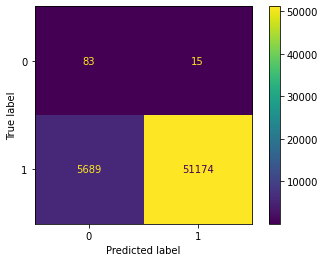

CPU times: user 14min 25s, sys: 15min 10s, total: 29min 36s
Wall time: 7min 33s


In [6]:
%%time

from sklearn.covariance import EllipticEnvelope

# contamination is an estimate of the rate of outliers
env = EllipticEnvelope(random_state=200, contamination = 0.1).fit(X_train)

show_predictions(env, X_test, y_test)

Trying this algorithm with a contamination of 0.1, 0.01 and 0.001 all gave poor results. It also takes about 30 minutes to run.

At 0.1 it had 57 TN, 41 FP, 5698 FN and 51165 TP

## One Class SVM (SDG)

The algorithm uses a support vector machine to create a frontier. On one side are the inliers and on the other the outliers. There are two main versions of this, the normal SVM that runs in quadratic time and the Stochastic Gradient Descent version that runs in linear time.

Given that this dataset has almost 285000 rows, I would have used the SDG version but Kaggle doesn't have an current version of SciKit Learn installed.

              precision    recall  f1-score   support

          -1       0.00      0.97      0.01        98
           1       1.00      0.50      0.67     56863

    accuracy                           0.50     56961
   macro avg       0.50      0.74      0.34     56961
weighted avg       1.00      0.50      0.67     56961



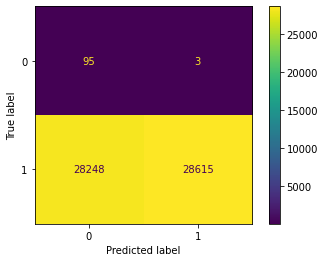

CPU times: user 1h 20min 5s, sys: 1.19 s, total: 1h 20min 6s
Wall time: 1h 20min 7s


In [7]:
%%time

from sklearn.svm import OneClassSVM

clf = OneClassSVM(gamma = 'auto')
clf.fit(X_train)
show_predictions(clf, X_test, y_test)

This code works but due to the size of the dataset takes over three hours to run and produces poor results

With given parameters it had 98 TN, 0 FP, 55089 FN and 1774 TP

## Isolation Forest

This technique creates an ensemble of decision trees to find rules that exclude the anomalies

              precision    recall  f1-score   support

          -1       0.04      0.85      0.08        98
           1       1.00      0.97      0.98     56863

    accuracy                           0.97     56961
   macro avg       0.52      0.91      0.53     56961
weighted avg       1.00      0.97      0.98     56961



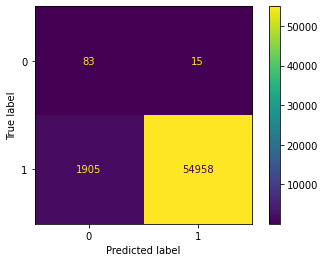

CPU times: user 3.73 s, sys: 160 ms, total: 3.89 s
Wall time: 3.73 s


In [8]:
%%time

from sklearn.ensemble import IsolationForest

isol = IsolationForest(random_state=200)
isol.fit(X_train)
show_predictions(isol, X_test, y_test)

## Local Outlier Factor

This method looks to see if the points have close neighbours. If they do then it finds them to be normal, if not then it finds them anomalous.
The number of neighbours it looks for is set as a hyperparameter

              precision    recall  f1-score   support

          -1       0.00      0.16      0.00        98
           1       1.00      0.87      0.93     56863

    accuracy                           0.87     56961
   macro avg       0.50      0.52      0.47     56961
weighted avg       1.00      0.87      0.93     56961



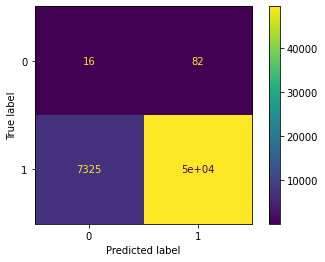

CPU times: user 12min 42s, sys: 273 ms, total: 12min 43s
Wall time: 12min 43s


In [9]:
%%time

from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=2, novelty=True)
lof.fit(X_train)
show_predictions(lof, X_test, y_test)

## SciKit Learn Summary

Of the four models implimented the isolation forest has generated the best results, followed by the Local Outlier Factor (LOF). The ecilptic envelope had similar results to the LOF model but took over thirty minutes to run compared to 9 seconds. The Support Vector Machine (SVM) produced surprisingly awful results and took over three hours to run, so while it is likely that this could be markedly improved by adjusting hyperperameters, this model is discounted due to time.

Attempts were made to adjust the hyperperameters on the Isolation Forest model and the LOF model but no significant change was noted.

## Auto Encoder

Autoencoders learn how to recreate data from only the normal instances. Once it is good at that all of the data is fed into it; any that it can recreate well are thought to be normal, any that it can't are thought to be abnormal.

In [10]:
# Import Libraries and data

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Split out training data into train and validation. 
ae_train = train.sample(frac=0.8, random_state=200)
ae_val = train.drop(ae_train.index)

# remove any fraudulent cases from the training data - we want to train it to know what good data should look like
ae_train = ae_train[ae_train.Class ==1]

ae_train.drop('Class', axis=1, inplace = True)
ae_val_dropped = ae_val.drop('Class', axis=1)

print(ae_val.shape, ae_train.shape)

(45569, 31) (181972, 30)


In [11]:
# Lets create our model

#input Layer
input_layer = layers.Input(shape=(30, ))
#Encoder
encoder = layers.Dense(15, activation="tanh",activity_regularizer=keras.regularizers.l2(0.0001))(input_layer)
encoder = layers.Dropout(0.2)(encoder)
encoder = layers.Dense(8, activation='relu')(encoder)
encoder = layers.Dense(4, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = layers.Dense(8, activation='relu')(encoder)
decoder= layers.Dropout(0.2)(decoder)
decoder = layers.Dense(15, activation='relu')(decoder)
decoder = layers.Dense(30, activation='tanh')(decoder)
#Autoencoder
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', restore_best_weights=True)
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 15)                465       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0     

In [12]:
# And now to train it
history = autoencoder.fit(ae_train, ae_train,
                    epochs=200,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(ae_val_dropped, ae_val_dropped),
                    verbose=1,
                    callbacks=[early_stop]
                    ).history

Epoch 1/200
1422/1422 [==============================] - 5s 3ms/step - loss: 0.9012 - accuracy: 0.3146 - val_loss: 0.8207 - val_accuracy: 0.3868
Epoch 2/200
1422/1422 [==============================] - 4s 3ms/step - loss: 0.8364 - accuracy: 0.3760 - val_loss: 0.8003 - val_accuracy: 0.4000
Epoch 3/200
1422/1422 [==============================] - 4s 3ms/step - loss: 0.8216 - accuracy: 0.3880 - val_loss: 0.7922 - val_accuracy: 0.4067
Epoch 4/200
1422/1422 [==============================] - 4s 3ms/step - loss: 0.8098 - accuracy: 0.3971 - val_loss: 0.7815 - val_accuracy: 0.4133
Epoch 5/200
1422/1422 [==============================] - 4s 3ms/step - loss: 0.8000 - accuracy: 0.4015 - val_loss: 0.7693 - val_accuracy: 0.4210
Epoch 6/200
1422/1422 [==============================] - 4s 3ms/step - loss: 0.7911 - accuracy: 0.4053 - val_loss: 0.7620 - val_accuracy: 0.4292
Epoch 7/200
1422/1422 [==============================] - 4s 3ms/step - loss: 0.7836 - accuracy: 0.4084 - val_loss: 0.7549 - val_ac

In [13]:
# Now that we have the autoencoder trained we need to start checking the data to see if we can spot the anomalies

# first we predict the normal data
normal_val = ae_val[ae_val.Class ==1]
anom_val = ae_val[ae_val.Class !=1]

normal_val.drop('Class', axis=1, inplace = True)
anom_val.drop('Class', axis=1, inplace = True)

reconstructions = autoencoder.predict(normal_val)

train_loss = tf.keras.losses.MAE(reconstructions, normal_val)

train_loss.shape

TensorShape([45480])

In [14]:
# then we predict the fraudulent data
anom_reconstructions = autoencoder.predict(anom_val)
anom_train_loss = keras.losses.mae(anom_reconstructions, anom_val)

In [15]:
# Lets experiment with thresholds. These can be done by eye but generally using the mean plus a multiple of the standard deviation has been explainability

# Experimenting with different numbers show that 2 works pretty well here
threshold_parameter = 2

inlier_mean = np.mean(train_loss)
inlier_std = np.std(train_loss)
threshold = inlier_mean + (threshold_parameter * inlier_std)

found_outliers = [x for x in anom_train_loss if x >= threshold]
not_found_outliers = [x for x in anom_train_loss if x < threshold]

print(f"Inlier mean = {inlier_mean:.4f}, Inlier Standard Deviation = {inlier_std:.4f}, Threshold = {threshold:.4f}, Number of found outliers = {len(found_outliers)}, Number of outliers not found = {len(not_found_outliers)}")

accuracy = len(found_outliers) / (len(found_outliers) + len(not_found_outliers))

print(f"Accuracy (for fraudulent data only) = {accuracy:.4f}")

Inlier mean = 0.4971, Inlier Standard Deviation = 0.2747, Threshold = 1.0466, Number of found outliers = 72, Number of outliers not found = 17
Accuracy (for fraudulent data only) = 0.8090


#### The reason autoencoders work is due to idea that good data will follow the set pattern but fraudulent data won't so if we loot at the losses of the good data we will find that they are all very similar

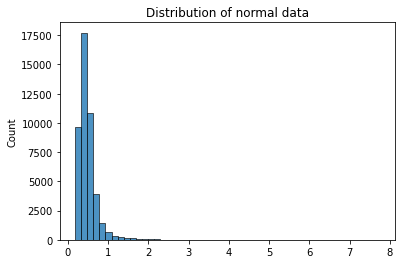

In [16]:
import seaborn as sns

sns.histplot(train_loss, bins=50, alpha=0.8).set_title('Distribution of normal data')
plt.show()

#### But the losses of the fraudulent data  are not

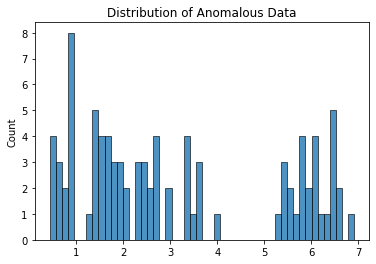

In [17]:
sns.histplot(anom_train_loss, bins=50, alpha=0.8).set_title('Distribution of Anomalous Data')
plt.show()

              precision    recall  f1-score   support

          -1       0.04      0.87      0.08        98
           1       1.00      0.97      0.98     56863

    accuracy                           0.97     56961
   macro avg       0.52      0.92      0.53     56961
weighted avg       1.00      0.97      0.98     56961



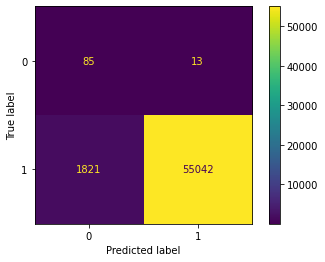

In [18]:
# So now lets put in the test data and see how it does on that

test_reconstructions = autoencoder.predict(X_test)
test_loss = keras.losses.mae(test_reconstructions,X_test)

predictions = [1 if x < threshold else -1 for x in test_loss]

cm = confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Conclusion

This dataset was tricky for all of the models, even the best instances that did find most of the anomalies were not able to find all of them and did also pick out over a thousand points that were not anomalous. This shows both that further checks would be required (such as a phone call asking if you had just used your card) and that criminals are sometimes able to conduct activities that are indestinguishable from legitimate purchases.

The autoencoder worked well overall as was expected from reputation within the field. The surprise was that it was equalled by the isolation forest, a much simplier and explainable method. The other methods used were not as accurate and, especially for the SVM, slower. This doesn't mean that they are not as good, just not right for this scenario.